In [1]:
import pathlib
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
import os
import cv2
import pandas as pd

In [3]:
df = pd.DataFrame({"image":[],
                         "label":[]})

In [4]:
for i in range(10):
  path = r"/content/gdrive/MyDrive/spectrograms/" + str(i)
  for j in os.listdir(path):
    img = cv2.imread(path + '/' + j)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img.resize((128,128))
    img = img/255
    df.loc[len(df)] = [img, i]

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


In [5]:
df

,image,label
0,"[[1.0, 1.0, 1.0, 1.0, 0.8901960784313725, 0.0,...",0.0
1,"[[1.0, 1.0, 1.0, 1.0, 0.8901960784313725, 0.0,...",0.0
2,"[[1.0, 1.0, 1.0, 1.0, 0.8901960784313725, 0.0,...",0.0
3,"[[1.0, 1.0, 1.0, 1.0, 0.8901960784313725, 0.0,...",0.0
4,"[[1.0, 1.0, 1.0, 1.0, 0.8901960784313725, 0.0,...",0.0
...,...,...
8727,"[[1.0, 1.0, 1.0, 1.0, 0.8901960784313725, 0.0,...",9.0
8728,"[[1.0, 1.0, 1.0, 1.0, 0.8901960784313725, 0.0,...",9.0
8729,"[[1.0, 1.0, 1.0, 1.0, 0.8901960784313725, 0.0,...",9.0
8730,"[[1.0, 1.0, 1.0, 1.0, 0.8901960784313725, 0.0,...",9.0


In [6]:
df = df.sample(frac = 1)

In [7]:
df["label"] = df["label"].astype(int)

In [36]:
df["image"] = [i.astype('float64') for i in df["image"]]

In [8]:
filename = "/content/spectrogram.csv" 
df.to_csv(filename, encoding='utf-8', index = False )

###  Modelling

In [19]:
import pandas as pd
import numpy as np
from  sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
import matplotlib.pyplot as plt

# Train-Test-Val Split

In [94]:
def train_test_val_split(data,target,test_ratio, val_ratio):
  X = data.drop(target, axis = 1)
  y = data[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_ratio, random_state=1)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, random_state=1)

  return  X_train, X_test, y_train, y_test, X_val, y_val

In [95]:
X_train, X_test, y_train, y_test, X_val, y_val = train_test_val_split(df,"label",0.2,0.1)

In [96]:
X_train.reset_index(drop = True,inplace = True)
X_test.reset_index(drop = True,inplace = True)
y_train.reset_index(drop = True,inplace = True)
y_test.reset_index(drop = True,inplace = True)
X_val.reset_index(drop = True,inplace = True)
y_val.reset_index(drop = True,inplace = True)

# Model Creation

In [108]:
def create_model(input_shape,class_count):
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape= input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(class_count, activation = 'softmax'))     

    return model 

In [116]:
def compile_model(model,optimizer,metrics):
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=metrics)

In [99]:
def fit_model(model,batch,epoch):
  history = model.fit(X_train, y_train,
                      batch_size=batch,
                      epochs=epoch,
                      verbose=0,
                      validation_data=(X_val, y_val),
                      shuffle=True)
  return history

In [117]:
input_shape = (128,128,1)
model = create_model(input_shape, 10)

In [118]:
metrics = ['accuracy']
compile_model(model,'adam', metrics)

In [102]:
X_train= tf.convert_to_tensor([np.array(i) for i in X_train.image])

In [105]:
X_val = tf.convert_to_tensor([np.array(i) for i in X_val.image])

In [120]:
import warnings
warnings.filterwarnings('ignore')
history = model.fit(X_train, y_train,
                      batch_size=32,
                      epochs=10,
                      validation_data=(X_val, y_val),
                      shuffle=True)

Epoch 1/10
197/197 [==============================] - 184s 937ms/step - loss: 2.0446 - accuracy: 0.2111 - val_loss: 2.0030 - val_accuracy: 0.2246
Epoch 2/10
197/197 [==============================] - 148s 752ms/step - loss: 1.9641 - accuracy: 0.2405 - val_loss: 1.9728 - val_accuracy: 0.1946
Epoch 3/10
197/197 [==============================] - 151s 764ms/step - loss: 1.9203 - accuracy: 0.2558 - val_loss: 1.9567 - val_accuracy: 0.2103
Epoch 4/10
197/197 [==============================] - 148s 753ms/step - loss: 1.8946 - accuracy: 0.2717 - val_loss: 1.9132 - val_accuracy: 0.2489
Epoch 5/10
197/197 [==============================] - 148s 752ms/step - loss: 1.8635 - accuracy: 0.2693 - val_loss: 1.9695 - val_accuracy: 0.2403
Epoch 6/10
197/197 [==============================] - 153s 778ms/step - loss: 1.8284 - accuracy: 0.2906 - val_loss: 1.9142 - val_accuracy: 0.2446
Epoch 7/10
197/197 [==============================] - 160s 811ms/step - loss: 1.8007 - accuracy: 0.2930 - val_loss: 1.9660 -

In [121]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


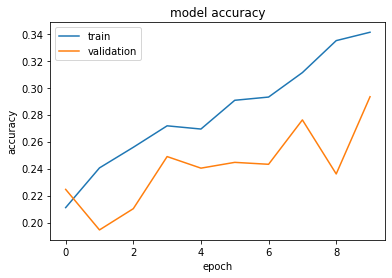

In [122]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

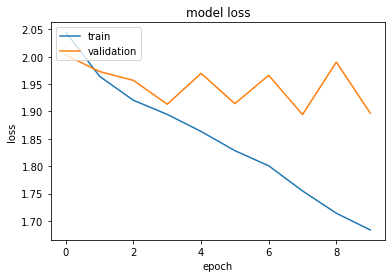

In [123]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Evaluate Test data

In [127]:
test_eval = model.evaluate(X_test, y_test)

55/55 [==============================] - 12s 214ms/step - loss: 1.8543 - accuracy: 0.2914


In [128]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.8542591333389282
Test accuracy: 0.29135662317276


# Prediction

In [134]:
predicted_classes = model.predict(X_test)

In [135]:
predicted_classes = np.argmax(predicted_classes,axis=1)

In [136]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(10)]
print(classification_report(y_test, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.63      0.12      0.20       205
     Class 1       0.17      0.05      0.08        77
     Class 2       0.23      0.12      0.16       204
     Class 3       0.14      0.05      0.07       219
     Class 4       0.63      0.48      0.54       181
     Class 5       0.47      0.18      0.27       179
     Class 6       0.69      0.72      0.71        72
     Class 7       0.61      0.48      0.54       194
     Class 8       0.17      0.88      0.28       186
     Class 9       0.19      0.07      0.11       230

    accuracy                           0.29      1747
   macro avg       0.39      0.32      0.29      1747
weighted avg       0.38      0.29      0.27      1747

